In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [2]:
def print_outliers(df):
    for column in df.select_dtypes(include=['int64', 'float64', 'float']):
        print(column)
        for threshold in [95, 90, 85, 80, 75]:
            upper_value = np.percentile(df[column], [threshold])[0]
            print('Beyond the lower {}th percentile there are {} outliers'.format(threshold, 
                len((np.where((df[column] > upper_value))[0]))
            ))
    print('\n')

In [3]:
def print_nulls(df):
    return df.isnull().sum()*100/df.isnull().isnull().count()

In [5]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

query1 = '''
SELECT
  *
FROM
  useducation
'''

df = pd.read_sql_query(query1, con=engine)
engine.dispose()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PRIMARY_KEY                   1492 non-null   object 
 1   STATE                         1492 non-null   object 
 2   YEAR                          1492 non-null   int64  
 3   ENROLL                        1229 non-null   float64
 4   TOTAL_REVENUE                 1280 non-null   float64
 5   FEDERAL_REVENUE               1280 non-null   float64
 6   STATE_REVENUE                 1280 non-null   float64
 7   LOCAL_REVENUE                 1280 non-null   float64
 8   TOTAL_EXPENDITURE             1280 non-null   float64
 9   INSTRUCTION_EXPENDITURE       1280 non-null   float64
 10  SUPPORT_SERVICES_EXPENDITURE  1280 non-null   float64
 11  OTHER_EXPENDITURE             1229 non-null   float64
 12  CAPITAL_OUTLAY_EXPENDITURE    1280 non-null   float64
 13  GRA

In [7]:
# all the columns we need to treat are float64
treat_columns = df.select_dtypes(include=['float64']).columns

# interpolate the data for each state
state_wise_inter = df.copy()

states = state_wise_inter["STATE"].unique()

for state in states:
    state_wise_inter.loc[state_wise_inter["STATE"] == state, treat_columns
                        ] = state_wise_inter.loc[state_wise_inter["STATE"] 
                                                 == state, treat_columns].interpolate(limit_direction='both')


# we drop the null values after interpolation
state_wise_inter.dropna(inplace=True)

In [8]:
state_wise_inter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1331 entries, 0 to 1491
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PRIMARY_KEY                   1331 non-null   object 
 1   STATE                         1331 non-null   object 
 2   YEAR                          1331 non-null   int64  
 3   ENROLL                        1331 non-null   float64
 4   TOTAL_REVENUE                 1331 non-null   float64
 5   FEDERAL_REVENUE               1331 non-null   float64
 6   STATE_REVENUE                 1331 non-null   float64
 7   LOCAL_REVENUE                 1331 non-null   float64
 8   TOTAL_EXPENDITURE             1331 non-null   float64
 9   INSTRUCTION_EXPENDITURE       1331 non-null   float64
 10  SUPPORT_SERVICES_EXPENDITURE  1331 non-null   float64
 11  OTHER_EXPENDITURE             1331 non-null   float64
 12  CAPITAL_OUTLAY_EXPENDITURE    1331 non-null   float64
 13  GRA

In [23]:
state_wise_inter.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,727716.0,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,260.276441
1,1992_ALASKA,ALASKA,1992,121156.0,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,223.833455,277.643071,211.547154,258.859712
2,1992_ARIZONA,ARIZONA,1992,676297.0,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,311432.0,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,5129788.0,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,269.197451


In [31]:
print_outliers(state_wise_inter)

YEAR
Beyond the lower 95th percentile there are 51 outliers
Beyond the lower 90th percentile there are 102 outliers
Beyond the lower 85th percentile there are 153 outliers
Beyond the lower 80th percentile there are 255 outliers
Beyond the lower 75th percentile there are 306 outliers
ENROLL
Beyond the lower 95th percentile there are 67 outliers
Beyond the lower 90th percentile there are 133 outliers
Beyond the lower 85th percentile there are 200 outliers
Beyond the lower 80th percentile there are 266 outliers
Beyond the lower 75th percentile there are 333 outliers
TOTAL_REVENUE
Beyond the lower 95th percentile there are 67 outliers
Beyond the lower 90th percentile there are 133 outliers
Beyond the lower 85th percentile there are 200 outliers
Beyond the lower 80th percentile there are 266 outliers
Beyond the lower 75th percentile there are 333 outliers
FEDERAL_REVENUE
Beyond the lower 95th percentile there are 67 outliers
Beyond the lower 90th percentile there are 133 outliers
Beyond the

### 1. Compute the average score for each row for all students weighted properly by grade. In other words, each row will have its own average. Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores.

In [24]:
state_wise_inter['weighted average'] = (
    (state_wise_inter['AVG_MATH_4_SCORE'] * state_wise_inter['GRADES_4_G'])
    + (state_wise_inter['AVG_READING_4_SCORE'] * state_wise_inter['GRADES_4_G'])
    + (state_wise_inter['AVG_MATH_8_SCORE'] * state_wise_inter['GRADES_8_G'])
    + (state_wise_inter['AVG_READING_8_SCORE'] * state_wise_inter['GRADES_8_G'])
) / ((state_wise_inter['GRADES_8_G'] + state_wise_inter['GRADES_4_G']) * 2)

In [33]:
# handle outliers after calculating the weighted average

winsorized = state_wise_inter.copy()

for column in state_wise_inter.select_dtypes(include=['int64', 'float64', 'float']):
    winsorized[column] = winsorize(state_wise_inter[column], (.05, .05))

### 2. What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?

In [51]:
winsorized[['INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 
                  'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE', 'weighted average']].corr()

,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,weighted average
INSTRUCTION_EXPENDITURE,1.000000,0.991412,0.949806,0.913566,0.171649
SUPPORT_SERVICES_EXPENDITURE,0.991412,1.000000,0.948715,0.917627,0.177012
OTHER_EXPENDITURE,0.949806,0.948715,1.000000,0.918287,0.102367
CAPITAL_OUTLAY_EXPENDITURE,0.913566,0.917627,0.918287,1.000000,0.094884
weighted average,0.171649,0.177012,0.102367,0.094884,1.000000


Correlation is weak between the weighted average and expenditures. Instruction expenditure is most strongly correlated with scores. 

### 3. Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?

In [54]:
var_set = winsorized[['INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 
                  'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']]


# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
scaled_var_set = StandardScaler().fit_transform(var_set)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = scaled_var_set.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[1.00075188 0.99215739 0.95051967 0.91425292]
 [0.99215739 1.00075188 0.94942822 0.91831674]
 [0.95051967 0.94942822 1.00075188 0.91897792]
 [0.91425292 0.91831674 0.91897792 1.00075188]]


In [37]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[-0.50469657 -0.50507618 -0.49959066 -0.49049831]
Eigenvalue 1: 3.8230918932758984
----------------------------------------
Eigenvector 2: 
[-0.70540384  0.70796948  0.02246862 -0.02607295]
Eigenvalue 2: 0.008502172177116366
----------------------------------------
Eigenvector 3: 
[-0.39338192 -0.3587144  -0.06833347  0.84374474]
Eigenvalue 3: 0.10965185353445912
----------------------------------------
Eigenvector 4: 
[ 0.30485646  0.33911833 -0.86326987  0.21639415]
Eigenvalue 4: 0.061761599809519924
----------------------------------------
The percentage of total variance in the dataset explained by each component calculated by hand.
 [0.95505489 0.00212395 0.02739237 0.0154288 ]


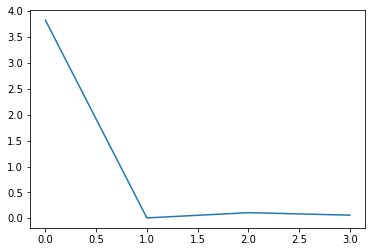

[3.82309189 0.00850217 0.10965185 0.0617616 ]


In [38]:
# print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

Nearly all of the variance is contained in the first component. 

## 4. What is the correlation between the overall score variable and the 1st principal component?

In [55]:
sklearn_pca = PCA(n_components=1)

winsorized['PCA_1'] = sklearn_pca.fit_transform(scaled_var_set)

In [57]:
winsorized[['weighted average', 'PCA_1', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 
                  'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']].corr()

,weighted average,PCA_1,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
weighted average,1.000000,0.140042,0.171649,0.177012,0.102367,0.094884
PCA_1,0.140042,1.000000,0.986449,0.987191,0.976469,0.958698
INSTRUCTION_EXPENDITURE,0.171649,0.986449,1.000000,0.991412,0.949806,0.913566
SUPPORT_SERVICES_EXPENDITURE,0.177012,0.987191,0.991412,1.000000,0.948715,0.917627
OTHER_EXPENDITURE,0.102367,0.976469,0.949806,0.948715,1.000000,0.918287
CAPITAL_OUTLAY_EXPENDITURE,0.094884,0.958698,0.913566,0.917627,0.918287,1.000000


## 5. If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

In this case PCA results in a component with less correlation to our target variable. It may be better to chose the most correlated variable, or to chose total expenditure. Because these variables are too closely correlated they are not suitable for PCA.

In [60]:
df['difference'] = df['GRADES_8_G'] - df['GRADES_4_G']

In [62]:
df['difference'].sum()

-364571.0